In [1]:
#imports
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from IPython.display import FileLink

In [2]:
# data file paths
train_df_path = '../input/petfinder-pawpularity-score/train.csv'
test_df_path = '../input/petfinder-pawpularity-score/test.csv'
train_data_path = '../input/petfinder-pawpularity-score/train'
test_data_path = '../input/petfinder-pawpularity-score/test'

checkpoint_filepath = 'save_models2'
checkpoint_filepath2 = 'save_models'


# global parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 528
TARGET = 'Pawpularity'
SEED = 88
BATCH_SIZE = 64
DROPOUT_RATE = 0.2
TEST_SIZE = .15
EPOCHS = 30
EPOCHS_2 = 10
DATA_SHAPE = 12

LEARNING_RATE = 1e-3
DECAY_STEPS = 100
DECAY_RATE = 0.96

In [3]:
df_train = pd.read_csv(train_df_path)
df_test = pd.read_csv(test_df_path)

print("The shape of train dataset: ", df_train.shape)
print("The shape of test dataset: ", df_test.shape)
print("######## Train ########")
display(df_train[:2])

The shape of train dataset:  (9912, 14)
The shape of test dataset:  (8, 13)
######## Train ########


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42


In [4]:
def join_path_train(Id):
    """Add path and .jpg to foto Id"""
    return os.path.join(train_data_path + "/" + Id + ".jpg")

def join_path_test(Id):
    """Add path and .jpg to foto Id"""
    return os.path.join(test_data_path + "/" + Id + ".jpg")

def join_jpg(Id):
    """Add .jpg to foto Id."""
    return os.path.join(Id + ".jpg") 


df_train["Path"] = df_train["Id"].apply(join_path_train)
df_train["Filename"] = df_train["Id"].apply(join_jpg)

df_test["Path"] = df_test["Id"].apply(join_path_test)
df_test["Filename"] = df_test["Id"].apply(join_jpg)


In [5]:
display(df_train.dtypes)

Id               object
Subject Focus     int64
Eyes              int64
Face              int64
Near              int64
Action            int64
Accessory         int64
Group             int64
Collage           int64
Human             int64
Occlusion         int64
Info              int64
Blur              int64
Pawpularity       int64
Path             object
Filename         object
dtype: object

In [6]:
def get_image(path, resize_method = 'mitchellcubic'):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], 
                            method = resize_method)
    image = tf.cast(image, dtype = tf.int32)
    return tf.keras.applications.efficientnet.preprocess_input(image)

def get_pair_of_dataset(path, label):
    return get_image(path), label

def get_dataset(x, label = None):
    if label is not None:
        return_set = tf.data.Dataset.from_tensor_slices((x, label))
        return return_set.map(get_pair_of_dataset)    \
                         .batch(BATCH_SIZE)           \
                         .prefetch(buffer_size = AUTOTUNE)
    else:
        return_set = tf.data.Dataset.from_tensor_slices(x)
        return return_set.map(get_image)              \
                         .batch(BATCH_SIZE)           \
                         .prefetch(buffer_size = AUTOTUNE)
    
    
def creat_dataset_metadata(df, drop_colums, label = None):

# creating dataset of image path and pawpularity score
    if label:
        input_dataset_data = tf.data.Dataset.from_tensor_slices(df.drop(['Id', 'Pawpularity', "Path", "Filename"], axis=1))
        input_dataset_img = tf.data.Dataset.from_tensor_slices(df["Path"]).map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
        output_dataset = tf.data.Dataset.from_tensor_slices(df[label])
        dataset = tf.data.Dataset.zip(((input_dataset_img, input_dataset_data), output_dataset))   \
                                    .batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)
        return dataset

    else:
        input_dataset_data = tf.data.Dataset.from_tensor_slices(df.drop(['Id', "Path", "Filename"], axis=1))
        input_dataset_img = tf.data.Dataset.from_tensor_slices(df["Path"]).map(get_image, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = tf.data.Dataset.zip(((input_dataset_img, input_dataset_data), ))   \
                                    .batch(BATCH_SIZE).prefetch(buffer_size = AUTOTUNE)

        return dataset




In [7]:
train_set, test_set = train_test_split( df_train,
                                       test_size=TEST_SIZE,
                                       shuffle=True,
                                       random_state=SEED)


train_set = creat_dataset_metadata(train_set, drop_colums = ['Id', 'Pawpularity', "Path", "Filename"], label = 'Pawpularity')
test_set = creat_dataset_metadata(test_set, drop_colums = ['Id', 'Pawpularity', "Path", "Filename"], label = 'Pawpularity')

In [8]:
X = df_train.drop(['Id', "Pawpularity"], axis=1)

In [9]:

model_EffNet = tf.keras.models.load_model("../input/keras-applications-models/EfficientNetB6.h5")

    
model_EffNet.trainable = False

augementation = tf.keras.Sequential(
        [
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomWidth(factor=(0.2, 0.3)), 
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3)),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
        ])


def get_model():
        # image model
        img_input = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name = "image input")
        x = augementation(img_input)
        x = model_EffNet(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
        img_output = tf.keras.layers.Dense(320, activation ='relu')(x)
        img_model = tf.keras.Model(img_input, img_output)
        
        
        # metadata model
        data_input = tf.keras.layers.Input(shape=DATA_SHAPE, name = "data input")
        x = tf.keras.layers.Dense(64, activation='relu')(data_input)
        #x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
        data_output = tf.keras.layers.Dense(32, activation='relu')(x)
        data_model = tf.keras.Model(data_input, data_output)

        # concatinating Model layers
        concat_layer = tf.keras.layers.Concatenate(name = 'concat_layer')([img_model.output, data_model.output])
        combined_dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(concat_layer)
        dense_combo = tf.keras.layers.Dense(256, activation='relu')(combined_dropout)           
        combined_batch = tf.keras.layers.BatchNormalization()(dense_combo)
        final_dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(combined_batch)
        combined_dence = tf.keras.layers.Dense(32, activation='relu')(final_dropout)   
        combined_batch = tf.keras.layers.BatchNormalization()(combined_dence)
        final_dropout = tf.keras.layers.Dropout(DROPOUT_RATE)(combined_batch)
        output_layer = tf.keras.layers.Dense(1, activation='relu')(final_dropout)

        model = tf.keras.Model(inputs = [img_model.input, data_model.input], outputs=output_layer)
    
        return model

model = get_model()


In [10]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE,
    staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                    loss=tf.keras.losses.MeanSquaredError(),
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])

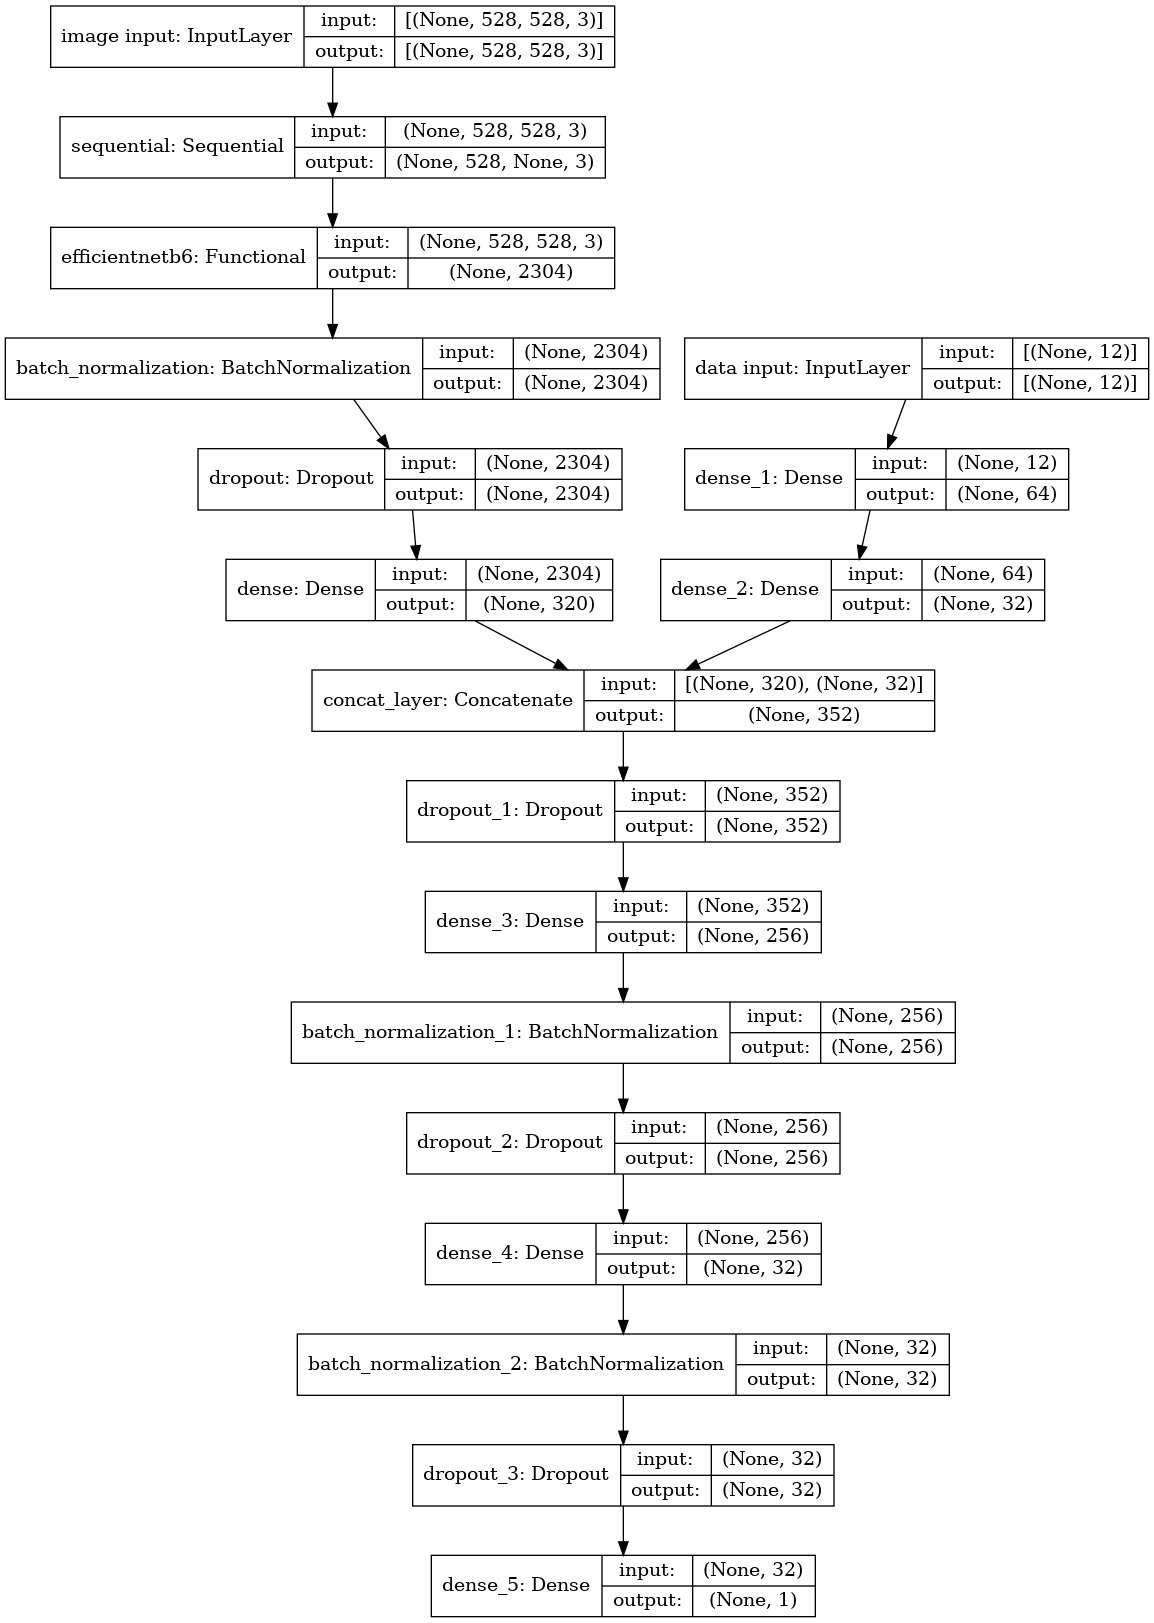

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [12]:


model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_root_mean_squared_error',
    mode='max',
    verbose = 1,
    save_best_only=True)



In [13]:
history = model.fit(
    train_set,
    validation_data = test_set, 
    epochs = EPOCHS,
    callbacks = [ model_checkpoint]# learning_rate_reduction, early_stopping],

    )

Epoch 1/30


  1/132 [..............................] - ETA: 55:58 - loss: 1931.3687 - root_mean_squared_error: 43.9473

  2/132 [..............................] - ETA: 7:16 - loss: 2072.0137 - root_mean_squared_error: 45.5194 

  3/132 [..............................] - ETA: 6:03 - loss: 1941.6084 - root_mean_squared_error: 44.0637

  4/132 [..............................] - ETA: 6:09 - loss: 1964.1924 - root_mean_squared_error: 44.3192

  5/132 [>.............................] - ETA: 6:04 - loss: 1890.3535 - root_mean_squared_error: 43.4782

  6/132 [>.............................] - ETA: 5:52 - loss: 1851.0404 - root_mean_squared_error: 43.0237

  7/132 [>.............................] - ETA: 5:47 - loss: 1864.3346 - root_mean_squared_error: 43.1779

  8/132 [>.............................] - ETA: 5:43 - loss: 1871.5924 - root_mean_squared_error: 43.2619

  9/132 [=>............................] - ETA: 5:32 - loss: 1904.6727 - root_mean_squared_error: 43.6426

 10/132 [=>............................] - ETA: 5:26 - loss: 1871.3279 - root_mean_squared_error: 43.2588

 11/132 [=>............................] - ETA: 5:19 - loss: 1871.6458 - root_mean_squared_error: 43.2625

 12/132 [=>............................] - ETA: 5:17 - loss: 1834.7974 - root_mean_squared_error: 42.8345

 13/132 [=>............................] - ETA: 5:15 - loss: 1815.3380 - root_mean_squared_error: 42.6068

 14/132 [==>...........................] - ETA: 5:09 - loss: 1816.4349 - root_mean_squared_error: 42.6197

 15/132 [==>...........................] - ETA: 5:03 - loss: 1790.9540 - root_mean_squared_error: 42.3197

 16/132 [==>...........................] - ETA: 4:58 - loss: 1793.0251 - root_mean_squared_error: 42.3441

 17/132 [==>...........................] - ETA: 4:52 - loss: 1774.6146 - root_mean_squared_error: 42.1262

 18/132 [===>..........................] - ETA: 4:48 - loss: 1763.5881 - root_mean_squared_error: 41.9951

 19/132 [===>..........................] - ETA: 4:43 - loss: 1775.8657 - root_mean_squared_error: 42.1410

 20/132 [===>..........................] - ETA: 4:42 - loss: 1761.0906 - root_mean_squared_error: 41.9654

 21/132 [===>..........................] - ETA: 4:38 - loss: 1757.1495 - root_mean_squared_error: 41.9184

 22/132 [====>.........................] - ETA: 4:34 - loss: 1768.4613 - root_mean_squared_error: 42.0531

 23/132 [====>.........................] - ETA: 4:33 - loss: 1758.5665 - root_mean_squared_error: 41.9353

 24/132 [====>.........................] - ETA: 4:29 - loss: 1761.4984 - root_mean_squared_error: 41.9702

 25/132 [====>.........................] - ETA: 4:25 - loss: 1762.6886 - root_mean_squared_error: 41.9844

 26/132 [====>.........................] - ETA: 4:23 - loss: 1758.0909 - root_mean_squared_error: 41.9296

 27/132 [=====>........................] - ETA: 4:22 - loss: 1770.0444 - root_mean_squared_error: 42.0719

 28/132 [=====>........................] - ETA: 4:18 - loss: 1761.1152 - root_mean_squared_error: 41.9656

 29/132 [=====>........................] - ETA: 4:16 - loss: 1750.4231 - root_mean_squared_error: 41.8381

 30/132 [=====>........................] - ETA: 4:13 - loss: 1739.6002 - root_mean_squared_error: 41.7085

 31/132 [======>.......................] - ETA: 4:12 - loss: 1724.2828 - root_mean_squared_error: 41.5245

 32/132 [======>.......................] - ETA: 4:08 - loss: 1713.9734 - root_mean_squared_error: 41.4002

 33/132 [======>.......................] - ETA: 4:05 - loss: 1707.7076 - root_mean_squared_error: 41.3244

 34/132 [======>.......................] - ETA: 4:01 - loss: 1711.2186 - root_mean_squared_error: 41.3669

 35/132 [======>.......................] - ETA: 3:58 - loss: 1714.1708 - root_mean_squared_error: 41.4025

 36/132 [=======>......................] - ETA: 3:55 - loss: 1713.1226 - root_mean_squared_error: 41.3899

 37/132 [=======>......................] - ETA: 3:52 - loss: 1714.7136 - root_mean_squared_error: 41.4091

 38/132 [=======>......................] - ETA: 3:49 - loss: 1725.3365 - root_mean_squared_error: 41.5372

 39/132 [=======>......................] - ETA: 3:46 - loss: 1720.1274 - root_mean_squared_error: 41.4744

 40/132 [========>.....................] - ETA: 3:43 - loss: 1727.1842 - root_mean_squared_error: 41.5594

 41/132 [========>.....................] - ETA: 3:41 - loss: 1740.4230 - root_mean_squared_error: 41.7184

 42/132 [========>.....................] - ETA: 3:39 - loss: 1735.2539 - root_mean_squared_error: 41.6564

 43/132 [========>.....................] - ETA: 3:36 - loss: 1725.2950 - root_mean_squared_error: 41.5367

 44/132 [=========>....................] - ETA: 3:33 - loss: 1717.9008 - root_mean_squared_error: 41.4476

 45/132 [=========>....................] - ETA: 3:31 - loss: 1724.2229 - root_mean_squared_error: 41.5238

 46/132 [=========>....................] - ETA: 3:28 - loss: 1720.2516 - root_mean_squared_error: 41.4759

 47/132 [=========>....................] - ETA: 3:26 - loss: 1725.9163 - root_mean_squared_error: 41.5441

 48/132 [=========>....................] - ETA: 3:23 - loss: 1728.6709 - root_mean_squared_error: 41.5773

 49/132 [==========>...................] - ETA: 3:21 - loss: 1732.2522 - root_mean_squared_error: 41.6203

 50/132 [==========>...................] - ETA: 3:18 - loss: 1727.7577 - root_mean_squared_error: 41.5663

 51/132 [==========>...................] - ETA: 3:15 - loss: 1725.5005 - root_mean_squared_error: 41.5391

 52/132 [==========>...................] - ETA: 3:13 - loss: 1727.0592 - root_mean_squared_error: 41.5579

 53/132 [===========>..................] - ETA: 3:10 - loss: 1715.9801 - root_mean_squared_error: 41.4244

 54/132 [===========>..................] - ETA: 3:08 - loss: 1708.7330 - root_mean_squared_error: 41.3368

 55/132 [===========>..................] - ETA: 3:05 - loss: 1711.1803 - root_mean_squared_error: 41.3664

 56/132 [===========>..................] - ETA: 3:03 - loss: 1706.6385 - root_mean_squared_error: 41.3115

 57/132 [===========>..................] - ETA: 3:00 - loss: 1702.0956 - root_mean_squared_error: 41.2565

 58/132 [============>.................] - ETA: 2:58 - loss: 1694.3219 - root_mean_squared_error: 41.1621

 59/132 [============>.................] - ETA: 2:55 - loss: 1694.5505 - root_mean_squared_error: 41.1649

 60/132 [============>.................] - ETA: 2:53 - loss: 1697.0564 - root_mean_squared_error: 41.1953

 61/132 [============>.................] - ETA: 2:50 - loss: 1692.2754 - root_mean_squared_error: 41.1373

 62/132 [=============>................] - ETA: 2:48 - loss: 1690.8409 - root_mean_squared_error: 41.1198

 63/132 [=============>................] - ETA: 2:45 - loss: 1692.2170 - root_mean_squared_error: 41.1366

 64/132 [=============>................] - ETA: 2:43 - loss: 1684.5326 - root_mean_squared_error: 41.0431

 65/132 [=============>................] - ETA: 2:40 - loss: 1685.5007 - root_mean_squared_error: 41.0549

 66/132 [==============>...............] - ETA: 2:38 - loss: 1680.8695 - root_mean_squared_error: 40.9984

 67/132 [==============>...............] - ETA: 2:35 - loss: 1679.5105 - root_mean_squared_error: 40.9818

 68/132 [==============>...............] - ETA: 2:32 - loss: 1677.4387 - root_mean_squared_error: 40.9565

 69/132 [==============>...............] - ETA: 2:30 - loss: 1674.4117 - root_mean_squared_error: 40.9196

 70/132 [==============>...............] - ETA: 2:28 - loss: 1672.4043 - root_mean_squared_error: 40.8950

 71/132 [===============>..............] - ETA: 2:26 - loss: 1670.9160 - root_mean_squared_error: 40.8768

 72/132 [===============>..............] - ETA: 2:23 - loss: 1669.0416 - root_mean_squared_error: 40.8539

 73/132 [===============>..............] - ETA: 2:21 - loss: 1666.3733 - root_mean_squared_error: 40.8212

 74/132 [===============>..............] - ETA: 2:18 - loss: 1666.6129 - root_mean_squared_error: 40.8242

 75/132 [================>.............] - ETA: 2:16 - loss: 1669.6158 - root_mean_squared_error: 40.8609

 76/132 [================>.............] - ETA: 2:13 - loss: 1662.3396 - root_mean_squared_error: 40.7718

 77/132 [================>.............] - ETA: 2:11 - loss: 1659.4288 - root_mean_squared_error: 40.7361

 78/132 [================>.............] - ETA: 2:08 - loss: 1655.6166 - root_mean_squared_error: 40.6893

 79/132 [================>.............] - ETA: 2:06 - loss: 1651.2399 - root_mean_squared_error: 40.6355

 80/132 [=================>............] - ETA: 2:03 - loss: 1648.5217 - root_mean_squared_error: 40.6020

 81/132 [=================>............] - ETA: 2:01 - loss: 1646.6327 - root_mean_squared_error: 40.5787

 82/132 [=================>............] - ETA: 1:58 - loss: 1646.1132 - root_mean_squared_error: 40.5723

 83/132 [=================>............] - ETA: 1:56 - loss: 1642.3528 - root_mean_squared_error: 40.5260

 84/132 [==================>...........] - ETA: 1:53 - loss: 1637.7932 - root_mean_squared_error: 40.4697

 85/132 [==================>...........] - ETA: 1:51 - loss: 1634.6204 - root_mean_squared_error: 40.4304

 86/132 [==================>...........] - ETA: 1:49 - loss: 1631.5258 - root_mean_squared_error: 40.3922

 87/132 [==================>...........] - ETA: 1:46 - loss: 1625.7329 - root_mean_squared_error: 40.3204

 88/132 [===================>..........] - ETA: 1:44 - loss: 1625.2430 - root_mean_squared_error: 40.3143

 89/132 [===================>..........] - ETA: 1:41 - loss: 1623.1123 - root_mean_squared_error: 40.2879

 90/132 [===================>..........] - ETA: 1:39 - loss: 1620.2970 - root_mean_squared_error: 40.2529

 91/132 [===================>..........] - ETA: 1:36 - loss: 1617.0198 - root_mean_squared_error: 40.2122

 92/132 [===================>..........] - ETA: 1:34 - loss: 1616.8597 - root_mean_squared_error: 40.2102

 93/132 [====================>.........] - ETA: 1:32 - loss: 1611.8844 - root_mean_squared_error: 40.1483

 94/132 [====================>.........] - ETA: 1:29 - loss: 1611.7141 - root_mean_squared_error: 40.1462

 95/132 [====================>.........] - ETA: 1:27 - loss: 1609.6772 - root_mean_squared_error: 40.1208

 96/132 [====================>.........] - ETA: 1:24 - loss: 1614.3073 - root_mean_squared_error: 40.1784

 97/132 [=====================>........] - ETA: 1:22 - loss: 1609.5675 - root_mean_squared_error: 40.1194

 98/132 [=====================>........] - ETA: 1:20 - loss: 1607.1423 - root_mean_squared_error: 40.0892

 99/132 [=====================>........] - ETA: 1:17 - loss: 1602.0948 - root_mean_squared_error: 40.0262

100/132 [=====================>........] - ETA: 1:15 - loss: 1600.3610 - root_mean_squared_error: 40.0045

101/132 [=====================>........] - ETA: 1:12 - loss: 1597.3669 - root_mean_squared_error: 39.9671

102/132 [======================>.......] - ETA: 1:10 - loss: 1596.1912 - root_mean_squared_error: 39.9524

103/132 [======================>.......] - ETA: 1:08 - loss: 1594.0906 - root_mean_squared_error: 39.9261

104/132 [======================>.......] - ETA: 1:05 - loss: 1596.7623 - root_mean_squared_error: 39.9595

105/132 [======================>.......] - ETA: 1:03 - loss: 1596.8459 - root_mean_squared_error: 39.9606

106/132 [=======================>......] - ETA: 1:00 - loss: 1596.6222 - root_mean_squared_error: 39.9578

107/132 [=======================>......] - ETA: 58s - loss: 1600.3654 - root_mean_squared_error: 40.0046 

108/132 [=======================>......] - ETA: 56s - loss: 1598.4764 - root_mean_squared_error: 39.9809

109/132 [=======================>......] - ETA: 53s - loss: 1598.8568 - root_mean_squared_error: 39.9857

110/132 [========================>.....] - ETA: 51s - loss: 1596.1434 - root_mean_squared_error: 39.9518

111/132 [========================>.....] - ETA: 49s - loss: 1591.9679 - root_mean_squared_error: 39.8995

112/132 [========================>.....] - ETA: 46s - loss: 1590.4481 - root_mean_squared_error: 39.8804

113/132 [========================>.....] - ETA: 44s - loss: 1589.3334 - root_mean_squared_error: 39.8664

114/132 [========================>.....] - ETA: 42s - loss: 1591.6420 - root_mean_squared_error: 39.8954

115/132 [=========================>....] - ETA: 39s - loss: 1589.0918 - root_mean_squared_error: 39.8634

116/132 [=========================>....] - ETA: 37s - loss: 1592.5795 - root_mean_squared_error: 39.9071

117/132 [=========================>....] - ETA: 35s - loss: 1592.1381 - root_mean_squared_error: 39.9016

118/132 [=========================>....] - ETA: 32s - loss: 1588.3245 - root_mean_squared_error: 39.8538

119/132 [==========================>...] - ETA: 30s - loss: 1585.8024 - root_mean_squared_error: 39.8221

120/132 [==========================>...] - ETA: 28s - loss: 1583.8365 - root_mean_squared_error: 39.7974

121/132 [==========================>...] - ETA: 25s - loss: 1580.6486 - root_mean_squared_error: 39.7574

122/132 [==========================>...] - ETA: 23s - loss: 1582.1611 - root_mean_squared_error: 39.7764

123/132 [==========================>...] - ETA: 20s - loss: 1579.3053 - root_mean_squared_error: 39.7405

124/132 [===========================>..] - ETA: 18s - loss: 1576.8538 - root_mean_squared_error: 39.7096

125/132 [===========================>..] - ETA: 16s - loss: 1575.6431 - root_mean_squared_error: 39.6944

126/132 [===========================>..] - ETA: 13s - loss: 1574.5482 - root_mean_squared_error: 39.6806

127/132 [===========================>..] - ETA: 11s - loss: 1574.6180 - root_mean_squared_error: 39.6815

128/132 [============================>.] - ETA: 9s - loss: 1571.9802 - root_mean_squared_error: 39.6482 

129/132 [============================>.] - ETA: 6s - loss: 1569.7102 - root_mean_squared_error: 39.6196

130/132 [============================>.] - ETA: 4s - loss: 1569.6073 - root_mean_squared_error: 39.6183

131/132 [============================>.] - ETA: 2s - loss: 1567.6678 - root_mean_squared_error: 39.5938

132/132 [==============================] - ETA: 0s - loss: 1566.3021 - root_mean_squared_error: 39.5765

132/132 [==============================] - 378s 3s/step - loss: 1566.3021 - root_mean_squared_error: 39.5765 - val_loss: 1280.1921 - val_root_mean_squared_error: 35.7798



Epoch 00001: val_root_mean_squared_error improved from -inf to 35.77977, saving model to save_models2


Epoch 2/30


  1/132 [..............................] - ETA: 7:35 - loss: 1436.3879 - root_mean_squared_error: 37.8997

  2/132 [..............................] - ETA: 4:47 - loss: 1569.8236 - root_mean_squared_error: 39.6210

  3/132 [..............................] - ETA: 4:52 - loss: 1477.5455 - root_mean_squared_error: 38.4389

  4/132 [..............................] - ETA: 4:50 - loss: 1492.1895 - root_mean_squared_error: 38.6289

  5/132 [>.............................] - ETA: 4:44 - loss: 1433.5500 - root_mean_squared_error: 37.8623

  6/132 [>.............................] - ETA: 4:40 - loss: 1414.6034 - root_mean_squared_error: 37.6112

  7/132 [>.............................] - ETA: 4:38 - loss: 1428.9510 - root_mean_squared_error: 37.8015

  8/132 [>.............................] - ETA: 4:35 - loss: 1440.0435 - root_mean_squared_error: 37.9479

  9/132 [=>............................] - ETA: 4:33 - loss: 1471.1274 - root_mean_squared_error: 38.3553

 10/132 [=>............................] - ETA: 4:29 - loss: 1453.3422 - root_mean_squared_error: 38.1227

 11/132 [=>............................] - ETA: 4:27 - loss: 1457.2524 - root_mean_squared_error: 38.1740

 12/132 [=>............................] - ETA: 4:24 - loss: 1427.7545 - root_mean_squared_error: 37.7856

 13/132 [=>............................] - ETA: 4:24 - loss: 1412.4949 - root_mean_squared_error: 37.5832

 14/132 [==>...........................] - ETA: 4:22 - loss: 1413.8082 - root_mean_squared_error: 37.6006

 15/132 [==>...........................] - ETA: 4:19 - loss: 1393.3395 - root_mean_squared_error: 37.3275

 16/132 [==>...........................] - ETA: 4:17 - loss: 1396.1285 - root_mean_squared_error: 37.3648

 17/132 [==>...........................] - ETA: 4:14 - loss: 1380.7495 - root_mean_squared_error: 37.1584

 18/132 [===>..........................] - ETA: 4:12 - loss: 1378.5284 - root_mean_squared_error: 37.1285

 19/132 [===>..........................] - ETA: 4:10 - loss: 1387.5287 - root_mean_squared_error: 37.2495

 20/132 [===>..........................] - ETA: 4:08 - loss: 1373.6973 - root_mean_squared_error: 37.0634

 21/132 [===>..........................] - ETA: 4:06 - loss: 1371.0171 - root_mean_squared_error: 37.0272

 22/132 [====>.........................] - ETA: 4:03 - loss: 1384.3680 - root_mean_squared_error: 37.2071

 23/132 [====>.........................] - ETA: 4:01 - loss: 1374.9792 - root_mean_squared_error: 37.0807

 24/132 [====>.........................] - ETA: 3:59 - loss: 1375.7538 - root_mean_squared_error: 37.0912

 25/132 [====>.........................] - ETA: 3:57 - loss: 1375.1316 - root_mean_squared_error: 37.0828

 26/132 [====>.........................] - ETA: 3:55 - loss: 1372.4055 - root_mean_squared_error: 37.0460

 27/132 [=====>........................] - ETA: 3:52 - loss: 1386.1671 - root_mean_squared_error: 37.2313

 28/132 [=====>........................] - ETA: 3:50 - loss: 1379.2814 - root_mean_squared_error: 37.1387

 29/132 [=====>........................] - ETA: 3:49 - loss: 1371.7240 - root_mean_squared_error: 37.0368

 30/132 [=====>........................] - ETA: 3:46 - loss: 1362.5975 - root_mean_squared_error: 36.9134

 31/132 [======>.......................] - ETA: 3:44 - loss: 1352.1774 - root_mean_squared_error: 36.7720

 32/132 [======>.......................] - ETA: 3:41 - loss: 1343.9338 - root_mean_squared_error: 36.6597

 33/132 [======>.......................] - ETA: 3:39 - loss: 1339.0944 - root_mean_squared_error: 36.5936

 34/132 [======>.......................] - ETA: 3:37 - loss: 1341.9426 - root_mean_squared_error: 36.6325

 35/132 [======>.......................] - ETA: 3:35 - loss: 1346.1749 - root_mean_squared_error: 36.6903

 36/132 [=======>......................] - ETA: 3:32 - loss: 1344.7732 - root_mean_squared_error: 36.6712

 37/132 [=======>......................] - ETA: 3:30 - loss: 1345.4554 - root_mean_squared_error: 36.6805

 38/132 [=======>......................] - ETA: 3:28 - loss: 1354.0043 - root_mean_squared_error: 36.7968

 39/132 [=======>......................] - ETA: 3:26 - loss: 1351.4736 - root_mean_squared_error: 36.7624

 40/132 [========>.....................] - ETA: 3:23 - loss: 1357.3662 - root_mean_squared_error: 36.8425

 41/132 [========>.....................] - ETA: 3:21 - loss: 1368.3447 - root_mean_squared_error: 36.9911

 42/132 [========>.....................] - ETA: 3:19 - loss: 1364.1302 - root_mean_squared_error: 36.9341

 43/132 [========>.....................] - ETA: 3:17 - loss: 1356.3973 - root_mean_squared_error: 36.8293

 44/132 [=========>....................] - ETA: 3:15 - loss: 1353.4205 - root_mean_squared_error: 36.7889

 45/132 [=========>....................] - ETA: 3:13 - loss: 1359.5736 - root_mean_squared_error: 36.8724

 46/132 [=========>....................] - ETA: 3:10 - loss: 1356.9501 - root_mean_squared_error: 36.8368

 47/132 [=========>....................] - ETA: 3:08 - loss: 1363.1260 - root_mean_squared_error: 36.9205

 48/132 [=========>....................] - ETA: 3:06 - loss: 1365.4545 - root_mean_squared_error: 36.9521

 49/132 [==========>...................] - ETA: 3:04 - loss: 1367.6801 - root_mean_squared_error: 36.9822

 50/132 [==========>...................] - ETA: 3:02 - loss: 1363.6757 - root_mean_squared_error: 36.9280

 51/132 [==========>...................] - ETA: 3:00 - loss: 1362.3923 - root_mean_squared_error: 36.9106

 52/132 [==========>...................] - ETA: 2:57 - loss: 1363.1417 - root_mean_squared_error: 36.9207

 53/132 [===========>..................] - ETA: 2:55 - loss: 1354.5481 - root_mean_squared_error: 36.8042

 54/132 [===========>..................] - ETA: 2:53 - loss: 1349.5405 - root_mean_squared_error: 36.7361

 55/132 [===========>..................] - ETA: 2:51 - loss: 1351.4264 - root_mean_squared_error: 36.7618

 56/132 [===========>..................] - ETA: 2:49 - loss: 1346.9923 - root_mean_squared_error: 36.7014

 57/132 [===========>..................] - ETA: 2:46 - loss: 1343.7886 - root_mean_squared_error: 36.6577

 58/132 [============>.................] - ETA: 2:44 - loss: 1337.8893 - root_mean_squared_error: 36.5772

 59/132 [============>.................] - ETA: 2:42 - loss: 1338.6007 - root_mean_squared_error: 36.5869

 60/132 [============>.................] - ETA: 2:40 - loss: 1340.6163 - root_mean_squared_error: 36.6144

 61/132 [============>.................] - ETA: 2:37 - loss: 1336.4219 - root_mean_squared_error: 36.5571

 62/132 [=============>................] - ETA: 2:35 - loss: 1334.6760 - root_mean_squared_error: 36.5332

 63/132 [=============>................] - ETA: 2:33 - loss: 1335.7563 - root_mean_squared_error: 36.5480

 64/132 [=============>................] - ETA: 2:31 - loss: 1329.0936 - root_mean_squared_error: 36.4567

 65/132 [=============>................] - ETA: 2:28 - loss: 1331.1903 - root_mean_squared_error: 36.4855

 66/132 [==============>...............] - ETA: 2:26 - loss: 1327.6582 - root_mean_squared_error: 36.4370

 67/132 [==============>...............] - ETA: 2:24 - loss: 1328.2319 - root_mean_squared_error: 36.4449

 68/132 [==============>...............] - ETA: 2:22 - loss: 1325.9281 - root_mean_squared_error: 36.4133

 69/132 [==============>...............] - ETA: 2:20 - loss: 1322.6484 - root_mean_squared_error: 36.3682

 70/132 [==============>...............] - ETA: 2:17 - loss: 1320.5161 - root_mean_squared_error: 36.3389

 71/132 [===============>..............] - ETA: 2:15 - loss: 1319.3787 - root_mean_squared_error: 36.3233

 72/132 [===============>..............] - ETA: 2:13 - loss: 1317.4417 - root_mean_squared_error: 36.2966

 73/132 [===============>..............] - ETA: 2:11 - loss: 1315.6871 - root_mean_squared_error: 36.2724

 74/132 [===============>..............] - ETA: 2:08 - loss: 1316.2004 - root_mean_squared_error: 36.2795

 75/132 [================>.............] - ETA: 2:06 - loss: 1319.7675 - root_mean_squared_error: 36.3286

 76/132 [================>.............] - ETA: 2:04 - loss: 1313.6123 - root_mean_squared_error: 36.2438

 77/132 [================>.............] - ETA: 2:02 - loss: 1310.8351 - root_mean_squared_error: 36.2055

 78/132 [================>.............] - ETA: 1:59 - loss: 1307.7168 - root_mean_squared_error: 36.1624

 79/132 [================>.............] - ETA: 1:57 - loss: 1304.5092 - root_mean_squared_error: 36.1180

 80/132 [=================>............] - ETA: 1:55 - loss: 1302.7743 - root_mean_squared_error: 36.0940

 81/132 [=================>............] - ETA: 1:53 - loss: 1301.6360 - root_mean_squared_error: 36.0782

 82/132 [=================>............] - ETA: 1:50 - loss: 1301.4581 - root_mean_squared_error: 36.0757

 83/132 [=================>............] - ETA: 1:48 - loss: 1298.7502 - root_mean_squared_error: 36.0382

 84/132 [==================>...........] - ETA: 1:46 - loss: 1294.6385 - root_mean_squared_error: 35.9811

 85/132 [==================>...........] - ETA: 1:44 - loss: 1291.6899 - root_mean_squared_error: 35.9401

 86/132 [==================>...........] - ETA: 1:42 - loss: 1288.9731 - root_mean_squared_error: 35.9023

 87/132 [==================>...........] - ETA: 1:39 - loss: 1284.3210 - root_mean_squared_error: 35.8374

 88/132 [===================>..........] - ETA: 1:37 - loss: 1284.2896 - root_mean_squared_error: 35.8370

 89/132 [===================>..........] - ETA: 1:35 - loss: 1282.0923 - root_mean_squared_error: 35.8063

 90/132 [===================>..........] - ETA: 1:33 - loss: 1280.0428 - root_mean_squared_error: 35.7777

 91/132 [===================>..........] - ETA: 1:31 - loss: 1277.2118 - root_mean_squared_error: 35.7381

 92/132 [===================>..........] - ETA: 1:28 - loss: 1278.1541 - root_mean_squared_error: 35.7513

 93/132 [====================>.........] - ETA: 1:26 - loss: 1274.5044 - root_mean_squared_error: 35.7002

 94/132 [====================>.........] - ETA: 1:24 - loss: 1274.1984 - root_mean_squared_error: 35.6959

 95/132 [====================>.........] - ETA: 1:22 - loss: 1272.4333 - root_mean_squared_error: 35.6712

 96/132 [====================>.........] - ETA: 1:20 - loss: 1276.3579 - root_mean_squared_error: 35.7262

 97/132 [=====================>........] - ETA: 1:17 - loss: 1272.8033 - root_mean_squared_error: 35.6764

 98/132 [=====================>........] - ETA: 1:15 - loss: 1271.4270 - root_mean_squared_error: 35.6571

 99/132 [=====================>........] - ETA: 1:13 - loss: 1267.7030 - root_mean_squared_error: 35.6048

100/132 [=====================>........] - ETA: 1:11 - loss: 1265.3767 - root_mean_squared_error: 35.5721

101/132 [=====================>........] - ETA: 1:09 - loss: 1262.9479 - root_mean_squared_error: 35.5380

102/132 [======================>.......] - ETA: 1:06 - loss: 1261.3839 - root_mean_squared_error: 35.5160

103/132 [======================>.......] - ETA: 1:04 - loss: 1259.9692 - root_mean_squared_error: 35.4960

104/132 [======================>.......] - ETA: 1:02 - loss: 1262.6941 - root_mean_squared_error: 35.5344

105/132 [======================>.......] - ETA: 1:00 - loss: 1262.1487 - root_mean_squared_error: 35.5267

106/132 [=======================>......] - ETA: 57s - loss: 1261.8529 - root_mean_squared_error: 35.5226 

107/132 [=======================>......] - ETA: 55s - loss: 1265.3318 - root_mean_squared_error: 35.5715

108/132 [=======================>......] - ETA: 53s - loss: 1263.9725 - root_mean_squared_error: 35.5524

109/132 [=======================>......] - ETA: 51s - loss: 1264.6056 - root_mean_squared_error: 35.5613

110/132 [========================>.....] - ETA: 49s - loss: 1262.3602 - root_mean_squared_error: 35.5297

111/132 [========================>.....] - ETA: 46s - loss: 1258.9147 - root_mean_squared_error: 35.4812

112/132 [========================>.....] - ETA: 44s - loss: 1257.0443 - root_mean_squared_error: 35.4548

113/132 [========================>.....] - ETA: 42s - loss: 1255.5295 - root_mean_squared_error: 35.4335

114/132 [========================>.....] - ETA: 40s - loss: 1257.1416 - root_mean_squared_error: 35.4562

115/132 [=========================>....] - ETA: 37s - loss: 1254.9709 - root_mean_squared_error: 35.4256

116/132 [=========================>....] - ETA: 35s - loss: 1258.4143 - root_mean_squared_error: 35.4741

117/132 [=========================>....] - ETA: 33s - loss: 1258.4139 - root_mean_squared_error: 35.4741

118/132 [=========================>....] - ETA: 31s - loss: 1255.9998 - root_mean_squared_error: 35.4401

119/132 [==========================>...] - ETA: 28s - loss: 1254.5625 - root_mean_squared_error: 35.4198

120/132 [==========================>...] - ETA: 26s - loss: 1252.5863 - root_mean_squared_error: 35.3919

121/132 [==========================>...] - ETA: 24s - loss: 1250.0555 - root_mean_squared_error: 35.3561

122/132 [==========================>...] - ETA: 22s - loss: 1250.9551 - root_mean_squared_error: 35.3688

123/132 [==========================>...] - ETA: 20s - loss: 1248.9521 - root_mean_squared_error: 35.3405

124/132 [===========================>..] - ETA: 17s - loss: 1246.9471 - root_mean_squared_error: 35.3121

125/132 [===========================>..] - ETA: 15s - loss: 1246.2887 - root_mean_squared_error: 35.3028

126/132 [===========================>..] - ETA: 13s - loss: 1245.4175 - root_mean_squared_error: 35.2905

127/132 [===========================>..] - ETA: 11s - loss: 1245.4949 - root_mean_squared_error: 35.2916

128/132 [============================>.] - ETA: 8s - loss: 1243.5535 - root_mean_squared_error: 35.2641 

129/132 [============================>.] - ETA: 6s - loss: 1242.0055 - root_mean_squared_error: 35.2421

130/132 [============================>.] - ETA: 4s - loss: 1241.0039 - root_mean_squared_error: 35.2279

131/132 [============================>.] - ETA: 2s - loss: 1239.2228 - root_mean_squared_error: 35.2026

132/132 [==============================] - ETA: 0s - loss: 1238.0305 - root_mean_squared_error: 35.1857

132/132 [==============================] - 337s 3s/step - loss: 1238.0305 - root_mean_squared_error: 35.1857 - val_loss: 1049.7290 - val_root_mean_squared_error: 32.3995



Epoch 00002: val_root_mean_squared_error did not improve from 35.77977


Epoch 3/30


  1/132 [..............................] - ETA: 7:13 - loss: 1115.7648 - root_mean_squared_error: 33.4031

  2/132 [..............................] - ETA: 4:55 - loss: 1260.6274 - root_mean_squared_error: 35.5053

  3/132 [..............................] - ETA: 4:53 - loss: 1183.6996 - root_mean_squared_error: 34.4049

  4/132 [..............................] - ETA: 4:51 - loss: 1172.6632 - root_mean_squared_error: 34.2442

  5/132 [>.............................] - ETA: 4:46 - loss: 1123.1482 - root_mean_squared_error: 33.5134

  6/132 [>.............................] - ETA: 4:40 - loss: 1102.1311 - root_mean_squared_error: 33.1984

  7/132 [>.............................] - ETA: 4:38 - loss: 1124.0404 - root_mean_squared_error: 33.5267

  8/132 [>.............................] - ETA: 4:35 - loss: 1144.4838 - root_mean_squared_error: 33.8302

  9/132 [=>............................] - ETA: 4:33 - loss: 1165.7389 - root_mean_squared_error: 34.1429

 10/132 [=>............................] - ETA: 4:30 - loss: 1154.1676 - root_mean_squared_error: 33.9730

 11/132 [=>............................] - ETA: 4:28 - loss: 1148.9028 - root_mean_squared_error: 33.8955

 12/132 [=>............................] - ETA: 4:27 - loss: 1127.7052 - root_mean_squared_error: 33.5813

 13/132 [=>............................] - ETA: 4:25 - loss: 1115.1653 - root_mean_squared_error: 33.3941

 14/132 [==>...........................] - ETA: 4:22 - loss: 1117.9208 - root_mean_squared_error: 33.4353

 15/132 [==>...........................] - ETA: 4:21 - loss: 1100.1504 - root_mean_squared_error: 33.1685

 16/132 [==>...........................] - ETA: 4:18 - loss: 1097.9971 - root_mean_squared_error: 33.1360

 17/132 [==>...........................] - ETA: 4:16 - loss: 1088.6140 - root_mean_squared_error: 32.9942

 18/132 [===>..........................] - ETA: 4:14 - loss: 1084.7769 - root_mean_squared_error: 32.9360

 19/132 [===>..........................] - ETA: 4:12 - loss: 1093.7504 - root_mean_squared_error: 33.0719

 20/132 [===>..........................] - ETA: 4:10 - loss: 1084.7073 - root_mean_squared_error: 32.9349

 21/132 [===>..........................] - ETA: 4:08 - loss: 1081.1727 - root_mean_squared_error: 32.8812

 22/132 [====>.........................] - ETA: 4:05 - loss: 1095.3167 - root_mean_squared_error: 33.0956

 23/132 [====>.........................] - ETA: 4:03 - loss: 1087.3838 - root_mean_squared_error: 32.9755

 24/132 [====>.........................] - ETA: 4:00 - loss: 1088.0321 - root_mean_squared_error: 32.9853

 25/132 [====>.........................] - ETA: 3:57 - loss: 1088.3315 - root_mean_squared_error: 32.9899

 26/132 [====>.........................] - ETA: 3:55 - loss: 1085.0070 - root_mean_squared_error: 32.9394

 27/132 [=====>........................] - ETA: 3:53 - loss: 1095.9819 - root_mean_squared_error: 33.1056

 28/132 [=====>........................] - ETA: 3:51 - loss: 1088.8254 - root_mean_squared_error: 32.9974

 29/132 [=====>........................] - ETA: 3:49 - loss: 1079.4976 - root_mean_squared_error: 32.8557

 30/132 [=====>........................] - ETA: 3:47 - loss: 1070.7526 - root_mean_squared_error: 32.7224

 31/132 [======>.......................] - ETA: 3:45 - loss: 1062.6609 - root_mean_squared_error: 32.5985

 32/132 [======>.......................] - ETA: 3:43 - loss: 1055.6604 - root_mean_squared_error: 32.4909

 33/132 [======>.......................] - ETA: 3:40 - loss: 1053.7651 - root_mean_squared_error: 32.4618

 34/132 [======>.......................] - ETA: 3:38 - loss: 1057.6406 - root_mean_squared_error: 32.5214

 35/132 [======>.......................] - ETA: 3:36 - loss: 1061.0834 - root_mean_squared_error: 32.5743

 36/132 [=======>......................] - ETA: 3:33 - loss: 1060.0315 - root_mean_squared_error: 32.5581

 37/132 [=======>......................] - ETA: 3:31 - loss: 1060.5807 - root_mean_squared_error: 32.5666

 38/132 [=======>......................] - ETA: 3:29 - loss: 1068.0054 - root_mean_squared_error: 32.6804

 39/132 [=======>......................] - ETA: 3:27 - loss: 1067.1052 - root_mean_squared_error: 32.6666

 40/132 [========>.....................] - ETA: 3:25 - loss: 1073.3427 - root_mean_squared_error: 32.7619

 41/132 [========>.....................] - ETA: 3:22 - loss: 1081.3137 - root_mean_squared_error: 32.8833

 42/132 [========>.....................] - ETA: 3:21 - loss: 1077.9797 - root_mean_squared_error: 32.8326

 43/132 [========>.....................] - ETA: 3:18 - loss: 1070.8997 - root_mean_squared_error: 32.7246

 44/132 [=========>....................] - ETA: 3:16 - loss: 1067.8450 - root_mean_squared_error: 32.6779

 45/132 [=========>....................] - ETA: 3:14 - loss: 1073.1354 - root_mean_squared_error: 32.7587

 46/132 [=========>....................] - ETA: 3:11 - loss: 1069.8868 - root_mean_squared_error: 32.7091

 47/132 [=========>....................] - ETA: 3:09 - loss: 1076.2710 - root_mean_squared_error: 32.8066

 48/132 [=========>....................] - ETA: 3:07 - loss: 1077.4152 - root_mean_squared_error: 32.8240

 49/132 [==========>...................] - ETA: 3:05 - loss: 1080.4994 - root_mean_squared_error: 32.8709

 50/132 [==========>...................] - ETA: 3:02 - loss: 1076.2592 - root_mean_squared_error: 32.8064

 51/132 [==========>...................] - ETA: 3:00 - loss: 1074.7228 - root_mean_squared_error: 32.7830

 52/132 [==========>...................] - ETA: 2:58 - loss: 1075.1931 - root_mean_squared_error: 32.7901

 53/132 [===========>..................] - ETA: 2:56 - loss: 1067.3014 - root_mean_squared_error: 32.6696

 54/132 [===========>..................] - ETA: 2:53 - loss: 1062.7955 - root_mean_squared_error: 32.6005

 55/132 [===========>..................] - ETA: 2:51 - loss: 1064.0819 - root_mean_squared_error: 32.6203

 56/132 [===========>..................] - ETA: 2:49 - loss: 1060.2604 - root_mean_squared_error: 32.5616

 57/132 [===========>..................] - ETA: 2:47 - loss: 1057.6831 - root_mean_squared_error: 32.5220

 58/132 [============>.................] - ETA: 2:45 - loss: 1051.6831 - root_mean_squared_error: 32.4297

 59/132 [============>.................] - ETA: 2:42 - loss: 1052.2524 - root_mean_squared_error: 32.4384

 60/132 [============>.................] - ETA: 2:40 - loss: 1054.7358 - root_mean_squared_error: 32.4767

 61/132 [============>.................] - ETA: 2:38 - loss: 1051.8683 - root_mean_squared_error: 32.4325

 62/132 [=============>................] - ETA: 2:36 - loss: 1050.6564 - root_mean_squared_error: 32.4138

 63/132 [=============>................] - ETA: 2:33 - loss: 1052.4675 - root_mean_squared_error: 32.4418

 64/132 [=============>................] - ETA: 2:31 - loss: 1047.1881 - root_mean_squared_error: 32.3603

 65/132 [=============>................] - ETA: 2:29 - loss: 1048.5751 - root_mean_squared_error: 32.3817

 66/132 [==============>...............] - ETA: 2:27 - loss: 1045.7417 - root_mean_squared_error: 32.3379

 67/132 [==============>...............] - ETA: 2:24 - loss: 1046.2509 - root_mean_squared_error: 32.3458

 68/132 [==============>...............] - ETA: 2:22 - loss: 1044.2303 - root_mean_squared_error: 32.3146

 69/132 [==============>...............] - ETA: 2:20 - loss: 1040.9442 - root_mean_squared_error: 32.2637

 70/132 [==============>...............] - ETA: 2:18 - loss: 1038.8090 - root_mean_squared_error: 32.2306

 71/132 [===============>..............] - ETA: 2:16 - loss: 1037.6707 - root_mean_squared_error: 32.2129

 72/132 [===============>..............] - ETA: 2:13 - loss: 1036.2168 - root_mean_squared_error: 32.1903

 73/132 [===============>..............] - ETA: 2:11 - loss: 1035.0164 - root_mean_squared_error: 32.1717

 74/132 [===============>..............] - ETA: 2:09 - loss: 1035.2504 - root_mean_squared_error: 32.1753

 75/132 [================>.............] - ETA: 2:07 - loss: 1038.0455 - root_mean_squared_error: 32.2187

 76/132 [================>.............] - ETA: 2:04 - loss: 1033.3416 - root_mean_squared_error: 32.1456

 77/132 [================>.............] - ETA: 2:02 - loss: 1030.4990 - root_mean_squared_error: 32.1014

 78/132 [================>.............] - ETA: 2:00 - loss: 1028.9004 - root_mean_squared_error: 32.0765

 79/132 [================>.............] - ETA: 1:58 - loss: 1026.0574 - root_mean_squared_error: 32.0321

 80/132 [=================>............] - ETA: 1:55 - loss: 1023.6336 - root_mean_squared_error: 31.9943

 81/132 [=================>............] - ETA: 1:53 - loss: 1022.8772 - root_mean_squared_error: 31.9825

 82/132 [=================>............] - ETA: 1:51 - loss: 1022.0411 - root_mean_squared_error: 31.9694

 83/132 [=================>............] - ETA: 1:49 - loss: 1019.8629 - root_mean_squared_error: 31.9353

 84/132 [==================>...........] - ETA: 1:46 - loss: 1016.6990 - root_mean_squared_error: 31.8857

 85/132 [==================>...........] - ETA: 1:44 - loss: 1014.2629 - root_mean_squared_error: 31.8475

 86/132 [==================>...........] - ETA: 1:42 - loss: 1012.7881 - root_mean_squared_error: 31.8243

 87/132 [==================>...........] - ETA: 1:40 - loss: 1008.4095 - root_mean_squared_error: 31.7555

 88/132 [===================>..........] - ETA: 1:38 - loss: 1008.8279 - root_mean_squared_error: 31.7621

 89/132 [===================>..........] - ETA: 1:35 - loss: 1006.6549 - root_mean_squared_error: 31.7278

 90/132 [===================>..........] - ETA: 1:33 - loss: 1006.0830 - root_mean_squared_error: 31.7188

 91/132 [===================>..........] - ETA: 1:31 - loss: 1003.4384 - root_mean_squared_error: 31.6771

 92/132 [===================>..........] - ETA: 1:29 - loss: 1003.9097 - root_mean_squared_error: 31.6845

 93/132 [====================>.........] - ETA: 1:26 - loss: 1000.8811 - root_mean_squared_error: 31.6367

 94/132 [====================>.........] - ETA: 1:24 - loss: 999.6533 - root_mean_squared_error: 31.6173 

 95/132 [====================>.........] - ETA: 1:22 - loss: 997.5173 - root_mean_squared_error: 31.5835

 96/132 [====================>.........] - ETA: 1:20 - loss: 1001.1769 - root_mean_squared_error: 31.6414

 97/132 [=====================>........] - ETA: 1:18 - loss: 998.2657 - root_mean_squared_error: 31.5953 

 98/132 [=====================>........] - ETA: 1:15 - loss: 997.6586 - root_mean_squared_error: 31.5857

 99/132 [=====================>........] - ETA: 1:13 - loss: 994.2126 - root_mean_squared_error: 31.5311

100/132 [=====================>........] - ETA: 1:11 - loss: 992.7092 - root_mean_squared_error: 31.5073

101/132 [=====================>........] - ETA: 1:09 - loss: 990.8322 - root_mean_squared_error: 31.4775

102/132 [======================>.......] - ETA: 1:06 - loss: 989.5539 - root_mean_squared_error: 31.4572

103/132 [======================>.......] - ETA: 1:04 - loss: 988.3307 - root_mean_squared_error: 31.4377

104/132 [======================>.......] - ETA: 1:02 - loss: 990.7416 - root_mean_squared_error: 31.4760

105/132 [======================>.......] - ETA: 1:00 - loss: 990.3681 - root_mean_squared_error: 31.4701

106/132 [=======================>......] - ETA: 57s - loss: 989.9290 - root_mean_squared_error: 31.4631 

107/132 [=======================>......] - ETA: 55s - loss: 993.1160 - root_mean_squared_error: 31.5137

108/132 [=======================>......] - ETA: 53s - loss: 991.7327 - root_mean_squared_error: 31.4918

109/132 [=======================>......] - ETA: 51s - loss: 992.2783 - root_mean_squared_error: 31.5004

110/132 [========================>.....] - ETA: 48s - loss: 990.3993 - root_mean_squared_error: 31.4706

111/132 [========================>.....] - ETA: 46s - loss: 987.4818 - root_mean_squared_error: 31.4242

112/132 [========================>.....] - ETA: 44s - loss: 985.8351 - root_mean_squared_error: 31.3980

In [ ]:
test_data = creat_dataset_metadata(df_test, drop_colums = ['Id', "Path", "Filename"])


In [ ]:
prediction =  model.predict(test_data)
df_test["Pawpularity"] = prediction
df_test[["Id","Pawpularity"]].to_csv('submission.csv', index=False)


In [ ]:
print(prediction)